<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [2]:
!pip install torchsummary

In [4]:
import os
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

In [5]:
# device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [7]:
image_size = 64
batch_size = 64

In [ ]:
transform = tt.Compose([
    tt.Resize(image_size),
    tt.ToTensor(),
#     tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    tt.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# path = '../../data/'
path = '/kaggle/input/faces-dataset-small'
image_folder = ImageFolder(path, transform=transform)

data_loader = DataLoader(image_folder, batch_size=batch_size, shuffle=True)

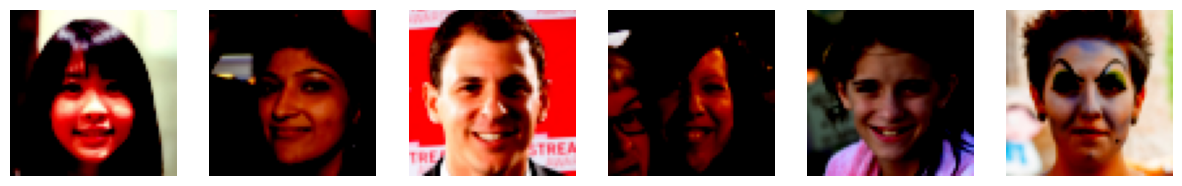

In [9]:
n = 6
fig, ax = plt.subplots(ncols=n, figsize=(15, 4))
for i in range(n):
    image = image_folder[i][0].permute(1, 2, 0)
    ax[i].imshow(image)
    ax[i].axis(False)
plt.show()

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [11]:
def block_discriminator(in_c, out_c, stride=2):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=4, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(out_c),
        nn.LeakyReLU(0.2, inplace=True),
    )

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block_1 = block_discriminator(3, 64)
        self.block_2 = block_discriminator(64, 128)
        self.block_3 = block_discriminator(128, 256)
        self.block_4 = block_discriminator(256, 512)
        # self.block_5 = block_discriminator(512, 512)
        self.conv_end = nn.Conv2d(512, 1, kernel_size=4, stride=2, bias=False)

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        # x = self.block_5(x)
        x = self.conv_end(x)
        x = x.view(x.shape[0], -1)
        x = torch.sigmoid(x)
        return x

discriminator = Discriminator()

In [7]:
summary(discriminator, (3, image_size, image_size))
None


Layer (type:depth-idx)                   Output Shape              Param #


├─Sequential: 1-1                        [-1, 64, 32, 32]          --

|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072

|    └─BatchNorm2d: 2-2                  [-1, 64, 32, 32]          128

|    └─LeakyReLU: 2-3                    [-1, 64, 32, 32]          --

├─Sequential: 1-2                        [-1, 128, 16, 16]         --

|    └─Conv2d: 2-4                       [-1, 128, 16, 16]         131,072

|    └─BatchNorm2d: 2-5                  [-1, 128, 16, 16]         256

|    └─LeakyReLU: 2-6                    [-1, 128, 16, 16]         --

├─Sequential: 1-3                        [-1, 256, 8, 8]           --

|    └─Conv2d: 2-7                       [-1, 256, 8, 8]           524,288

|    └─BatchNorm2d: 2-8                  [-1, 256, 8, 8]           512

|    └─LeakyReLU: 2-9                    [-1, 256, 8, 8]           --

├─Sequential: 1-4                        [-1, 512, 4, 

In [13]:
class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True) + 1e-8)

class GeneratorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, latent_size):
        super(GeneratorBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.pix_norm = PixelNorm()

    def forward(self, x):
        x = self.pix_norm(x)
        x = self.upsample(x)
        x = self.conv1(x)
        x = self.pix_norm(x)
        x = self.conv2(x)
        return x

class Generator(nn.Module):
    def __init__(self, latent_size, num_channels, num_blocks):
        super(Generator, self).__init__()
        self.initial_block = nn.ConvTranspose2d(latent_size, num_channels, kernel_size=4, stride=1, padding=0)
        self.blocks = nn.ModuleList([
            GeneratorBlock(num_channels, num_channels, latent_size) for _ in range(num_blocks)
        ])
        self.final_block = nn.Conv2d(num_channels, 3, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.initial_block(x)
        for block in self.blocks:
            x = block(x)
        x = self.final_block(x)
        return x

latent_size = 100
num_channels = 256
num_blocks = 4

generator = Generator(latent_size, num_channels, num_blocks)

In [14]:
summary(generator, (latent_size, 1, 1))
None


Layer (type:depth-idx)                   Output Shape              Param #


├─ConvTranspose2d: 1-1                   [-1, 256, 4, 4]           409,856

├─ModuleList: 1                          []                        --

|    └─GeneratorBlock: 2-1               [-1, 256, 8, 8]           --

|    |    └─PixelNorm: 3-1               [-1, 256, 4, 4]           --

|    |    └─Upsample: 3-2                [-1, 256, 8, 8]           --

|    |    └─Conv2d: 3-3                  [-1, 256, 8, 8]           590,080

|    |    └─PixelNorm: 3-4               [-1, 256, 8, 8]           --

|    |    └─Conv2d: 3-5                  [-1, 256, 8, 8]           590,080

|    └─GeneratorBlock: 2-2               [-1, 256, 16, 16]         --

|    |    └─PixelNorm: 3-6               [-1, 256, 8, 8]           --

|    |    └─Upsample: 3-7                [-1, 256, 16, 16]         --

|    |    └─Conv2d: 3-8                  [-1, 256, 16, 16]         590,080

|    |    └─PixelNorm: 3-9               [-1, 256,

In [ ]:
# latent_size = 100

# def block_generator(in_c, out_c, stride=1, padding=1):
#     return nn.Sequential(
#         nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=stride, padding=padding, bias=False),
#         nn.BatchNorm2d(out_c),
#         nn.ReLU(inplace=True)
#     )

# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.block_1 = block_generator(latent_size, 1024)
#         self.block_2 = block_generator(1024, 512, 2)
#         self.block_3 = block_generator(512, 256, 2)
#         self.block_4 = block_generator(256, 128, 2)
#         self.block_5 = block_generator(128, 64, 2)
#         self.conv_end = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False)

#     def forward(self, x):
#         x = self.block_1(x)
#         x = self.block_2(x)
#         x = self.block_3(x)
#         x = self.block_4(x)
#         x = self.block_5(x)
#         x = self.conv_end(x)
#         x = torch.tanh(x)
#         return x

# generator = Generator()

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [15]:
def fit(model, opt, loss_func, epochs, data_loader):
    model['discriminator'].train()
    model['generator'].train()
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    for epoch in tqdm(range(epochs)):
        _losses_d = []
        _losses_g = []
        for x, _ in tqdm(data_loader, desc=f'Epoch: {epoch+1}'):
            x = x.to(device)
            real_labels = torch.FloatTensor(x.shape[0], 1).uniform_(0.95, 1.0).to(device)
            fake_labels = torch.FloatTensor(x.shape[0], 1).uniform_(0.0, 0.05).to(device)
            z = torch.randn(x.shape[0], latent_size, 1, 1, device=device)
            
            # learning discriminator
            opt['discriminator'].zero_grad()
            outputs_real = model['discriminator'](x)

            d_loss_real = loss_func['discriminator'](outputs_real, real_labels)
            real_score = torch.mean(outputs_real).item()    
            
            x_hat = model['generator'](z)
            outputs_fake = model['discriminator'](x_hat.detach())
            d_loss_fake = loss_func['discriminator'](outputs_fake, fake_labels)
            fake_score = torch.mean(outputs_fake).item()

            loss_d = d_loss_real + d_loss_fake
            loss_d.backward()
            opt['discriminator'].step()
            _losses_d.append(loss_d.item())

            # learning generator
            opt['generator'].zero_grad()
            x_hat = model['generator'](z)
            outputs_fake = model['discriminator'](x_hat)
            loss_g = loss_func['generator'](outputs_fake, real_labels)

            loss_g.backward()
            opt['generator'].step()
            _losses_g.append(loss_g.item())
            
        losses_g.append(np.mean(_losses_g))
        losses_d.append(np.mean(_losses_d))
        real_scores.append(np.mean(real_score))
        fake_scores.append(np.mean(fake_score))
        
        print(f'losses_g = {round(losses_g[-1], 5)},   losses_d = {round(losses_d[-1], 5)}')
        print(f'real_scores = {round(real_scores[-1], 5)},   fake_scores = {round(fake_scores[-1], 5)}')
        n = 4
        fig, ax = plt.subplots(ncols=n, figsize=(10, 4))
        z = torch.randn(n, latent_size, 1, 1, device=device)
        x_hat = model['generator'](z)
        for i in range(4):
            img = x_hat[i].permute(1, 2, 0).cpu().detach().numpy()
            ax[i].imshow(img)
            ax[i].axis(False)
        plt.show()
        
    return losses_g, losses_d, real_scores, fake_scores

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 3.81704,   losses_d = 0.43079
real_scores = 0.92322,   fake_scores = 0.04698


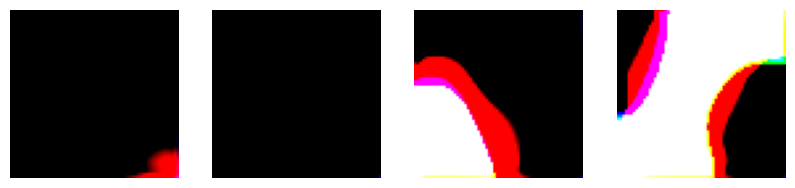

Epoch: 2:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 3.82514,   losses_d = 0.25918
real_scores = 0.96086,   fake_scores = 0.02671


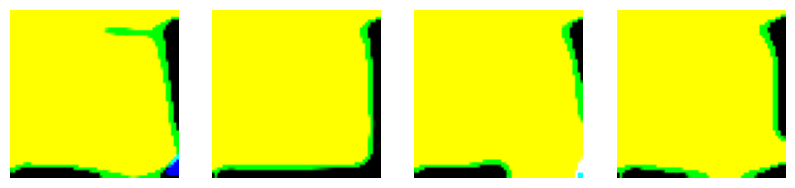

Epoch: 3:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 4.03564,   losses_d = 0.25742
real_scores = 0.9413,   fake_scores = 0.03555


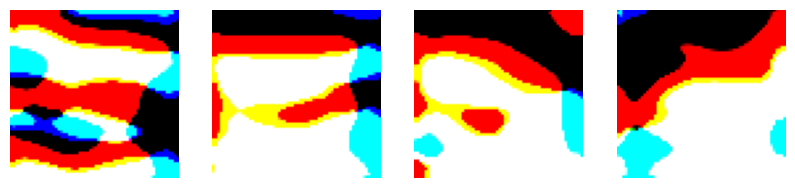

Epoch: 4:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 4.01289,   losses_d = 0.25638
real_scores = 0.98611,   fake_scores = 0.03996


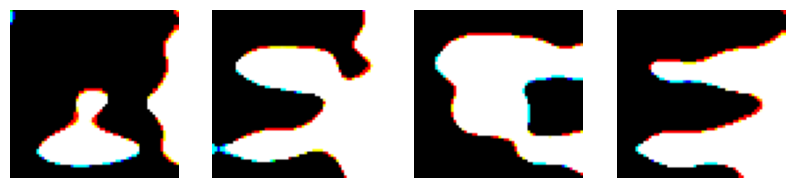

Epoch: 5:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 3.88498,   losses_d = 0.2532
real_scores = 0.91856,   fake_scores = 0.03345


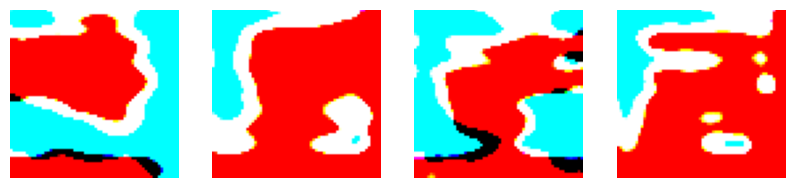

Epoch: 6:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 4.02983,   losses_d = 0.25085
real_scores = 0.98398,   fake_scores = 0.03032


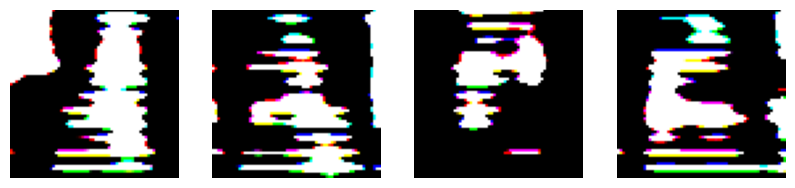

Epoch: 7:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 3.97482,   losses_d = 0.24664
real_scores = 0.98801,   fake_scores = 0.03259


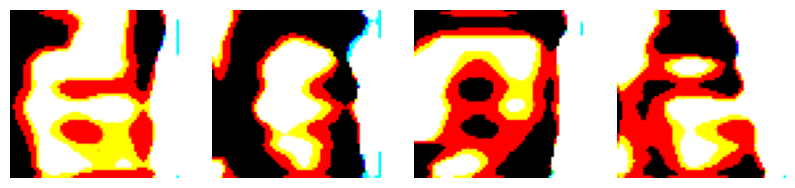

Epoch: 8:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 4.08321,   losses_d = 0.24969
real_scores = 0.98701,   fake_scores = 0.02441


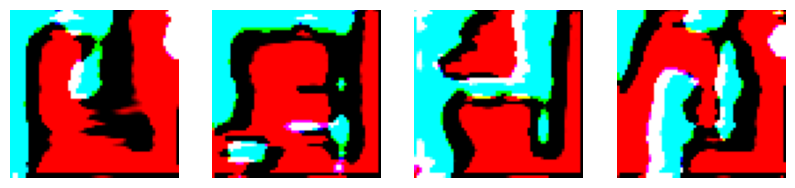

Epoch: 9:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 4.19932,   losses_d = 0.24691
real_scores = 0.99086,   fake_scores = 0.03467


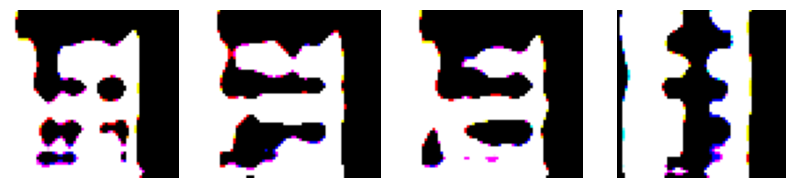

Epoch: 10:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 4.00856,   losses_d = 0.24975
real_scores = 0.94773,   fake_scores = 0.00865


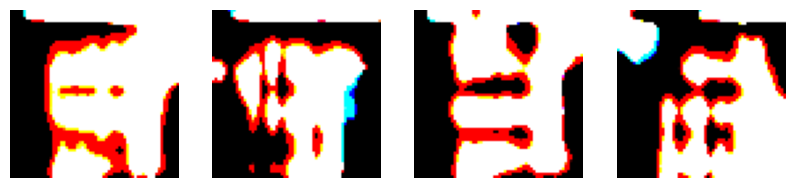

Epoch: 11:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 3.93015,   losses_d = 0.24379
real_scores = 0.95431,   fake_scores = 0.05343


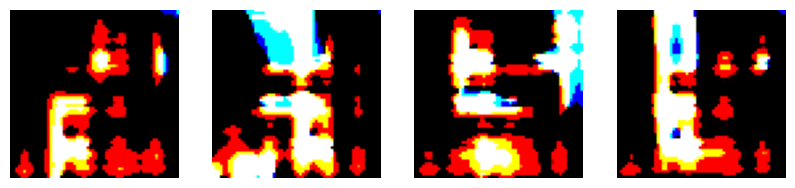

Epoch: 12:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 4.16321,   losses_d = 0.24992
real_scores = 0.93868,   fake_scores = 0.03784


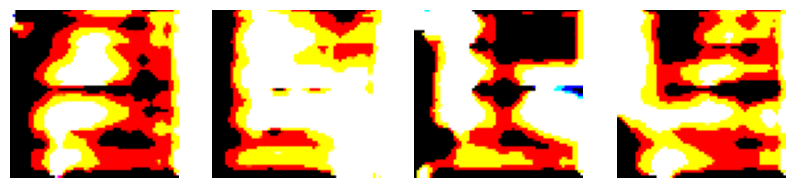

Epoch: 13:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 4.03356,   losses_d = 0.25294
real_scores = 0.95037,   fake_scores = 0.03446


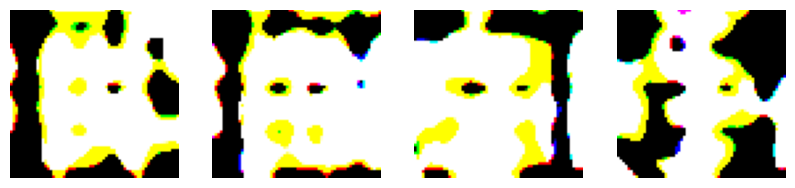

Epoch: 15:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 4.25671,   losses_d = 0.2522
real_scores = 0.96416,   fake_scores = 0.03596


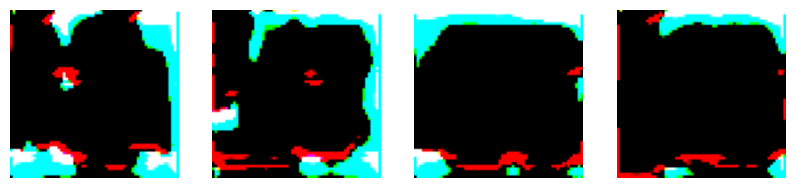

Epoch: 16:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 4.29392,   losses_d = 0.25895
real_scores = 0.99435,   fake_scores = 0.04935


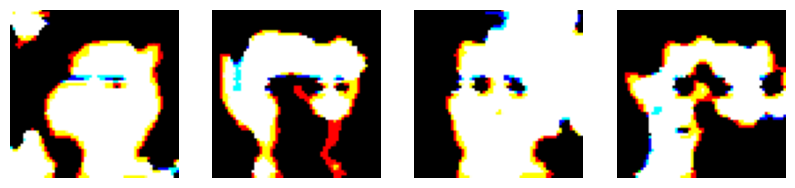

Epoch: 17:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 3.94136,   losses_d = 0.24951
real_scores = 0.92151,   fake_scores = 0.01765


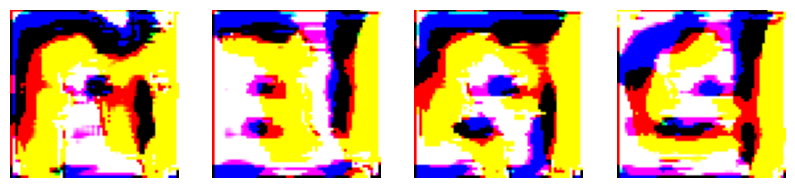

Epoch: 18:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 4.07744,   losses_d = 0.24752
real_scores = 0.95975,   fake_scores = 0.03116


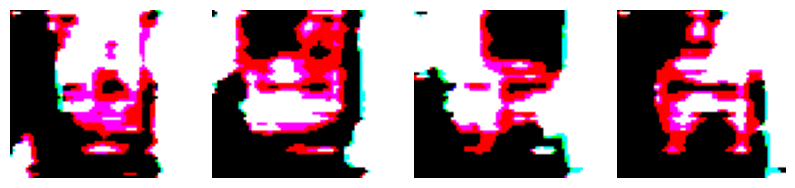

Epoch: 19:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 4.2739,   losses_d = 0.2505
real_scores = 0.99293,   fake_scores = 0.07883


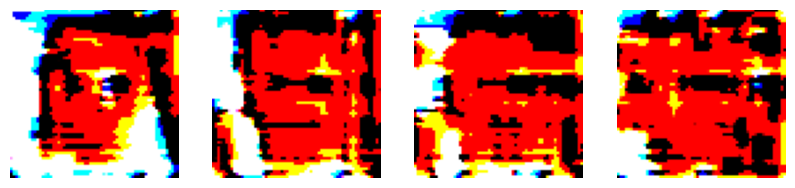

Epoch: 20:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 4.52794,   losses_d = 0.25774
real_scores = 0.94447,   fake_scores = 0.03754


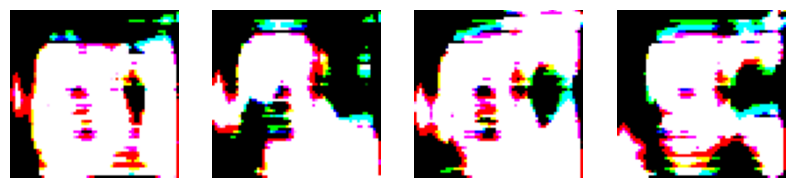

Epoch: 21:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 4.09794,   losses_d = 0.2484
real_scores = 0.95826,   fake_scores = 0.0453


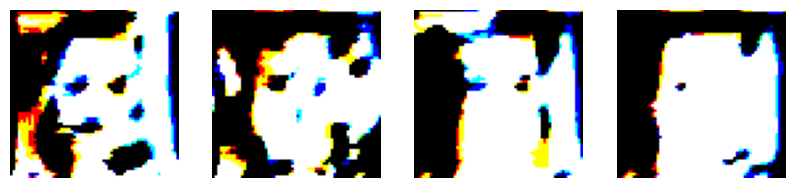

Epoch: 22:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 4.3522,   losses_d = 0.24842
real_scores = 0.98866,   fake_scores = 0.01929


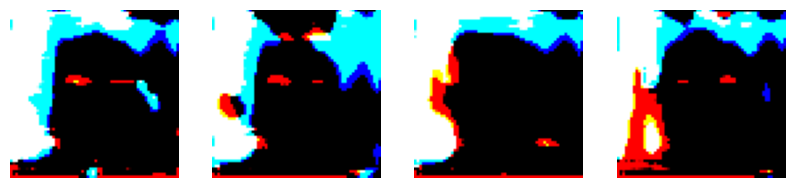

Epoch: 23:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 3.97506,   losses_d = 0.24242
real_scores = 0.96864,   fake_scores = 0.02639


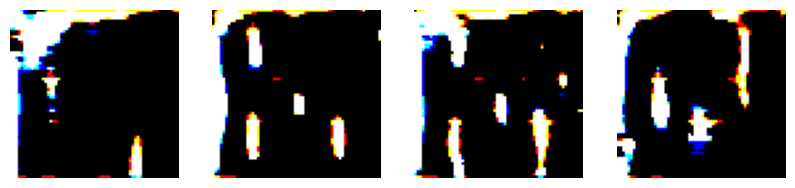

Epoch: 24:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 3.91101,   losses_d = 0.24277
real_scores = 0.97746,   fake_scores = 0.0742


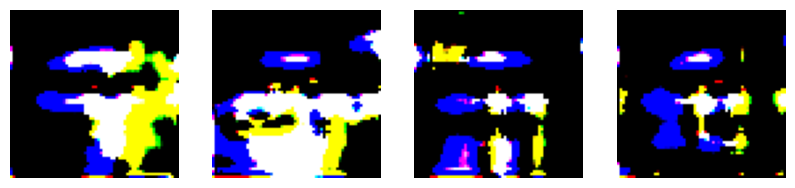

Epoch: 25:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 4.07714,   losses_d = 0.2436
real_scores = 0.99395,   fake_scores = 0.03474


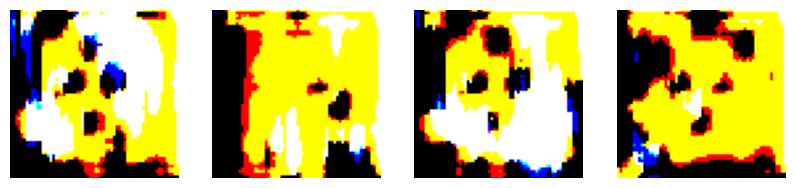

Epoch: 26:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 3.94258,   losses_d = 0.24569
real_scores = 0.97523,   fake_scores = 0.01901


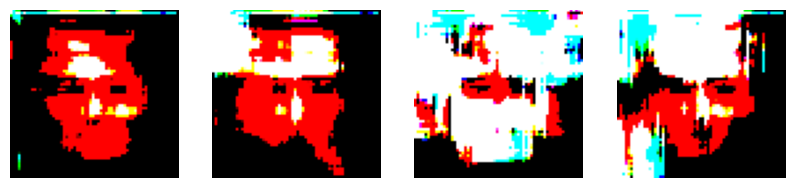

Epoch: 27:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 4.15039,   losses_d = 0.25351
real_scores = 0.98457,   fake_scores = 0.00837


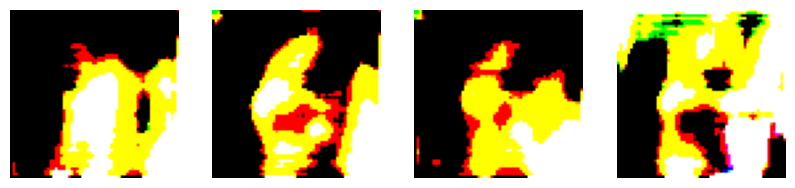

Epoch: 28:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 4.0311,   losses_d = 0.24666
real_scores = 0.97997,   fake_scores = 0.0704


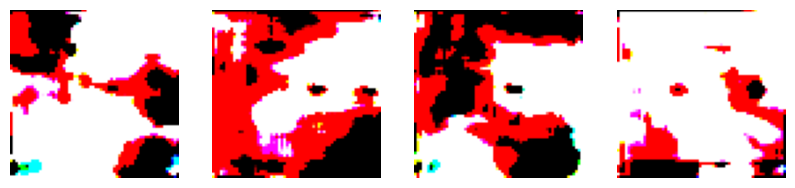

Epoch: 29:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 3.96943,   losses_d = 0.25069
real_scores = 0.98704,   fake_scores = 0.04017


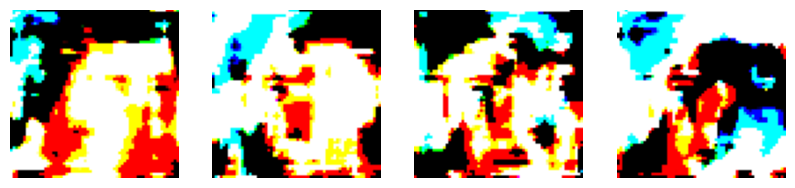

Epoch: 30:   0%|          | 0/50 [00:00<?, ?it/s]

losses_g = 4.14379,   losses_d = 0.24885
real_scores = 0.8891,   fake_scores = 0.00863


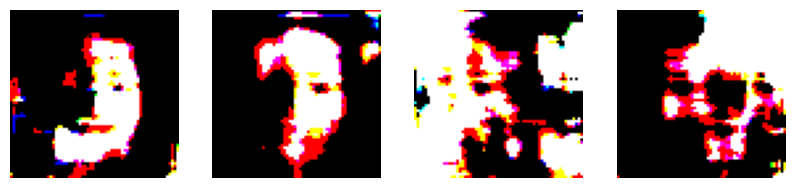

In [16]:
model = {
    'discriminator': discriminator,
    'generator': generator
}
model['discriminator'].to(device)
model['generator'].to(device)
loss_func = {
    'discriminator': nn.BCELoss(),
    'generator': nn.BCELoss()
}
lr = 0.0002
opt = {
    'discriminator': torch.optim.Adam(model['discriminator'].parameters(), lr = lr),
    'generator': torch.optim.Adam(model['generator'].parameters(), lr = lr)
}

epochs = 30
losses_g, losses_d, real_scores, fake_scores = fit(model, opt, loss_func, epochs, data_loader)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize(15, 4))

x = range(epochs)
sns.lineplot(x=x, y=losses_g, label='losses_g', ax=ax[0])
sns.lineplot(x=x, y=losses_d, label='losses_d', ax=ax[0])

sns.lineplot(x=x, y=real_scores, label='real_scores', ax=ax[1])
sns.lineplot(x=x, y=fake_scores, label='fake_scores', ax=ax[1])

ax[0].set_xticks(range(epochs+1))
ax[1].set_xticks(range(epochs+1))
plt.legend()
plt.show()

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [ ]:
def show_images(generated):
  # TODO: show generated images
  pass

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

Прокомментируйте получившийся результат: